In [13]:

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


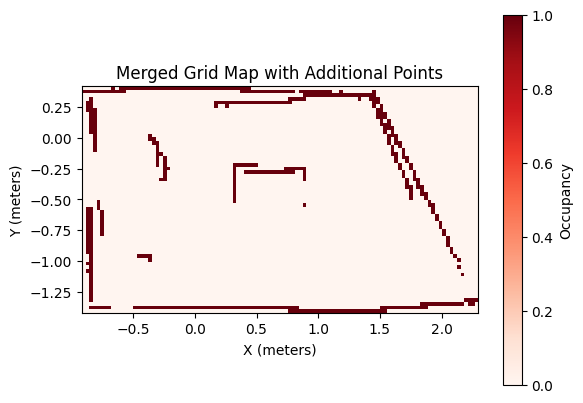

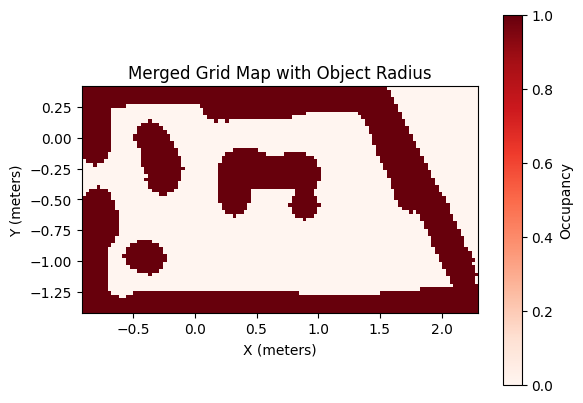

(30, 47)
No path found from start to goal.
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import heapq

import numpy as np
import pandas as pd

# Load data
df1 = pd.read_csv('usdata.csv')
df2 = pd.read_csv('usdata2.csv')

x1, y1 = df1['x'].values, df1['y'].values
x2, y2 = df2['x'].values, df2['y'].values

# Transformation parameters for data2
translation_vector_2 = np.array([1.0, 0.0])  # Shift data2 x-coordinate to the left by 1 unit

# Apply the translation to data2
transformed_x2 = x2 + translation_vector_2[0]
transformed_y2 = y2 + translation_vector_2[1]

# Combine all points into a single dataset
all_x = np.concatenate((x1, transformed_x2))
all_y = np.concatenate((y1, transformed_y2))

x_min, x_max = np.min(all_x), np.max(all_x)
y_min, y_max = np.min(all_y), np.max(all_y)

# Define the grid resolution
resolution = 0.03  # Size of each grid cell in meters

# Calculate grid dimensions based on bounds and resolution
grid_width = int(np.ceil((x_max - x_min) / resolution))
grid_height = int(np.ceil((y_max - y_min) / resolution))

# Initialize the grid map with zeros (free space)
grid_map = np.zeros((grid_height, grid_width))


# Helper function to convert coordinates to grid indices
def to_grid_indices(x, y, x_min, y_min, resolution):
    grid_x = int((x - x_min) / resolution)
    grid_y = int((y - y_min) / resolution)
    return grid_x, grid_y

for x, y in zip(all_x, all_y):
    grid_x, grid_y = to_grid_indices(x, y, x_min, y_min, resolution)
    if 0 <= grid_x < grid_width and 0 <= grid_y < grid_height:
      grid_map[grid_y, grid_x] = 1  # Mark as occupied

# Helper function to mark cells as occupied
def mark_cells(grid_map, x_points, y_points, x_min, y_min, resolution):
    for x, y in zip(x_points, y_points):
        grid_x, grid_y = to_grid_indices(x, y, x_min, y_min, resolution)
        if 0 <= grid_x < grid_map.shape[1] and 0 <= grid_y < grid_map.shape[0]:
            grid_map[grid_y, grid_x] = 1  # Mark as occupied


# Mark existing points on the grid map
mark_cells(grid_map, all_x, all_y, x_min, y_min, resolution)

# Example: Add a rectangular region (x, y) = (0.3, 0.75) to (0.75, 0.75)
x_start, x_end = 0.3, 0.75
y_start, y_end = 0.75, 0.75

# Generate a range of points within the specified region
x_points = np.linspace(x_start, x_end, int((x_end - x_start) / resolution) + 1)
y_points = np.linspace(y_start, y_end, int((y_end - y_start) / resolution) + 1)

# Mark new points on the grid map
mark_cells(grid_map, x_points, y_points, x_min, y_min, resolution)

# Visualize the merged grid map
plt.imshow(grid_map, cmap='Reds', origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.title("Merged Grid Map with Additional Points")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.colorbar(label="Occupancy")
plt.show()

# Function to mark cells within a given radius as occupied
def mark_occupied(grid_map, grid_x, grid_y, radius, resolution):
    radius_in_cells = int(np.ceil(radius / resolution))
    for dx in range(-radius_in_cells, radius_in_cells + 1):
        for dy in range(-radius_in_cells, radius_in_cells + 1):
            if dx**2 + dy**2 <= radius_in_cells**2:
                nx, ny = grid_x + dx, grid_y + dy
                if 0 <= nx < grid_map.shape[1] and 0 <= ny < grid_map.shape[0]:
                    grid_map[ny, nx] = 1

# Extend the occupied cells to account for the object radius
object_radius = 0.1  # Radius of the object in meters
for x, y in zip(all_x, all_y):
    grid_x, grid_y = to_grid_indices(x, y, x_min, y_min, resolution)
    if 0 <= grid_x < grid_width and 0 <= grid_y < grid_height:
        mark_occupied(grid_map, grid_x, grid_y, object_radius, resolution)

# Visualize the grid map with occupied cells extended
plt.imshow(grid_map, cmap='Reds', origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.title("Merged Grid Map with Object Radius")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.colorbar(label="Occupancy")
plt.show()

np.save('map4.npy', grid_map)
# Define A* algorithm for pathfinding
def astar(grid_map, start, goal):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    open_set = []
    heapq.heappush(open_set, (0, start))
    g_costs = {start: 0}
    f_costs = {start: heuristic(start, goal)}
    came_from = {}

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            return reconstruct_path(came_from, current)

        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])

            if not (0 <= neighbor[0] < grid_map.shape[1] and 0 <= neighbor[1] < grid_map.shape[0]):
                continue
            if grid_map[neighbor[1], neighbor[0]] == 1:
                continue

            tentative_g_cost = g_costs[current] + (1.414 if direction[0] != 0 and direction[1] != 0 else 1)

            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                came_from[neighbor] = current
                g_costs[neighbor] = tentative_g_cost
                f_costs[neighbor] = tentative_g_cost + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_costs[neighbor], neighbor))

    return None

def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

# Define start and goal positions in grid coordinates
start = to_grid_indices(0.0, 0.0, x_min, y_min, resolution)
goal = to_grid_indices(1.0, 1.0, x_min, y_min, resolution)

print(to_grid_indices(0,0,x_min,y_min,resolution))

# Run A* algorithm
path = astar(grid_map, start, goal)

np.save("path7.npy", np.array(path))

# Plot the grid map and the path
if path:
    for (x, y) in path:
        grid_map[y, x] = 2  # Mark the path with a different value

    plt.imshow(grid_map, cmap='Reds', origin='lower', extent=[x_min, x_max, y_min, y_max])
    plt.title("Merged Grid Map with A* Path")
    plt.xlabel("X (meters)")
    plt.ylabel("Y (meters)")
    plt.colorbar(label="Occupancy")
    plt.show()
else:
    print("No path found from start to goal.")

print(grid_map)